# Frequency-switched Data Reduction
-----------------------------------

This notebook shows how to use `dysh` to calibrate a frequency switched observations. The idea is similar to an OnOff observation, except the telescope does not move to an Off in position on the sky, but moves its IF in frequency space. Here we call the On and Off the Sig and Ref, but both will have the signal, just shifted in the band. Since the telescope observes in a Track mode, combining the sig and a shifted (folded) ref, a $\sqrt{2}$ improvement in S/N can be achieved.

It retrieves and calibrates frequency-switched scans using `GBTFITSLoad.getfs()`, which returns a `ScanBlock` object.  

## First some standard imports, plus a small helper function 

In [1]:
import os
import wget
import astropy.units as u
from dysh.fits.gbtfitsload import GBTFITSLoad
import dysh.util as util
import numpy as np
from dysh.util.files import dysh_data

In [2]:
# show the mean and std for data and for a 1-rolled data
def rolled_stats(data):
    delta = data[1:] - data[:-1]
    print('stats:',data.mean(), data.std(), delta.mean(), delta.std())

# to test, check that rolled_stats has a sqrt(2) higher RMS
rolled_stats(np.random.normal(0,1,10000))

stats: -0.009410137883931939 1.0007689135743352 0.0001264997341369234 1.4224670119396199


## First, we download the example SDFITS data, if necessary.


In [3]:
filename = dysh_data(example="getfs")

In [4]:
sdfits = GBTFITSLoad(filename)
sdfits.info()
sdfits.summary()

Filename: /home/teuben/GBT/dysh_data/example_data/fs-L/data/AGBT20B_014_03.raw.vegas/AGBT20B_014_03.raw.vegas.A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   ()      
  1  SINGLE DISH    1 BinTableHDU    245   352R x 74C   ['32A', '1D', '22A', '1D', '1D', '1D', '16384E', '16A', '6A', '8A', '1D', '1D', '1D', '4A', '1D', '4A', '1D', '1I', '32A', '32A', '1J', '32A', '16A', '1E', '8A', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '8A', '1D', '1D', '12A', '1I', '1I', '1D', '1D', '1I', '1A', '1I', '1I', '16A', '16A', '1J', '1J', '22A', '1D', '1D', '1I', '1A', '1D', '1E', '1D', '1D', '1D', '1D', '1D', '1A', '1A', '8A', '1E', '1E', '16A', '1I', '1I', '1I']   


,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,6,M33S,0.0,Track,1,1.606184,1.420405,4,2,11,1,72.712573,28.957453


### Now retrieve and calibrate the frequency-switched scan
The default is to fold the sig and ref to create the final spectrum.  Use `fold=False` to not fold them and `use_sig=False` to reverse the role of sig and ref. Here we pick scan=6 (there is only 1, so we could ignore it), ifnum=0 (there are 4) and plnum=1 (there are 2):

In [5]:
fsscan = sdfits.getfs(scan=6, ifnum=0, plnum=1)

/home/teuben/GBT/dysh/src/dysh/spectra/core.py:350: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng] - caloff[chrng])


In [6]:
ta = fsscan.timeaverage(weights='tsys')

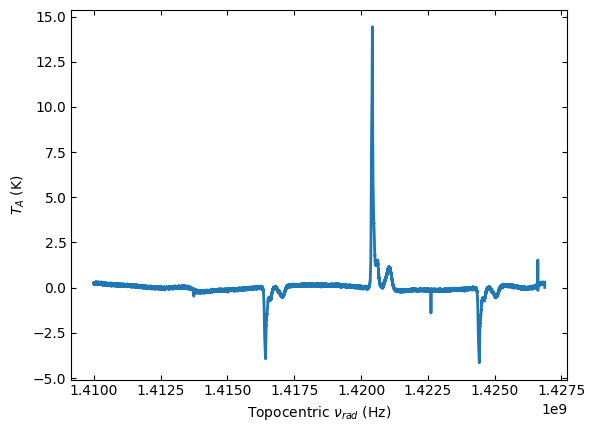

In [7]:
ta.plot()

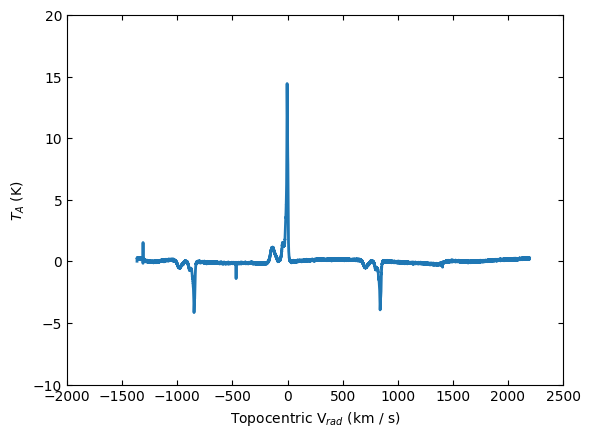

In [8]:
ta.plot(xaxis_unit="km/s",yaxis_unit="K",ymin=-10,ymax=20,xmin=-2000,xmax=2500)

### Plot X axis in channel units and remove a baseline with a compound inclusion region.

For baseline subtraction either include= or exclude can be used, but not both.
Right now, such compound regions only work in channel space (an issue is filed on this)

Note the default baseline model is a **chebyshev** polynomial model. For a classic polynomial model with higher degree one may need to normalize the frequency axis in channel space using normalize=True, to prevent poorly conditioned fits, but this will not allow you to undo the fit.

Valid models currently are:    **chebyshev**, **hermite**, **legendre** and classic **polynomial**.

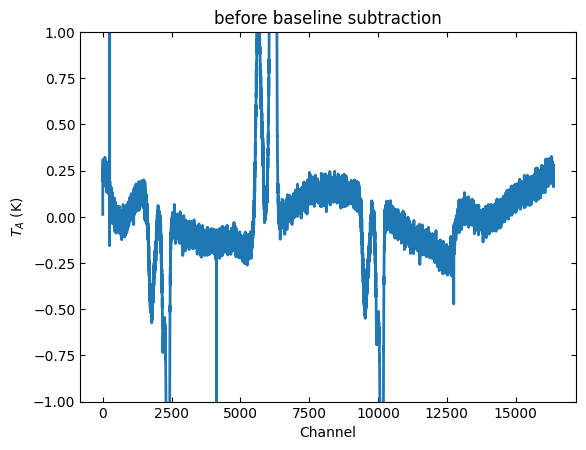

stats: -0.142315958298121 K 0.03631059232266146 K -0.00010205442179552853 K 0.04198114224875007 K
EXCLUDING [Spectral Region, 1 sub-regions:
  (1422548362.4257812 Hz, 1426874229.125 Hz) 
, Spectral Region, 1 sub-regions:
  (1420076438.5976562 Hz, 1421415397.3378906 Hz) 
, Spectral Region, 1 sub-regions:
  (1410000259.0932617 Hz, 1419046470.3359375 Hz) 
]
stats: -0.0038519059744210517 K 0.03878679509350842 K -0.00011453049613087338 K 0.04198116951039622 K
stats: 0.004509137806761875 K 0.03609075213317604 K -0.00010070197520245566 K 0.04213951694546889 K


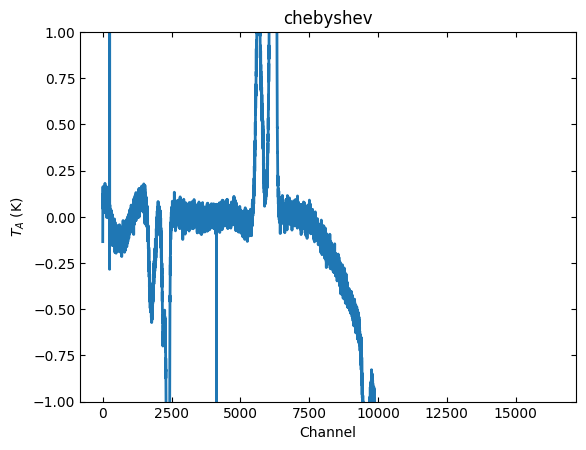

In [9]:
model = 'chebyshev'

ta.plot(xaxis_unit="chan",yaxis_unit="K",ymin=-1,ymax=1, title='before baseline subtraction')
rolled_stats(ta.flux[4200:5300])
ta.baseline(degree=3,include=[(4200,5300),(6600,7600)], remove=True, model=model)
rolled_stats(ta.flux[4200:5300])
rolled_stats(ta.flux[6600:7600])
ta.plot(xaxis_unit="chan",yaxis_unit="K",ymin=-1,ymax=1, title=model)


Now we will undo this baseline fit, and plot it again to see if we get the same spectrum back. Also adding the statistics on the first section of the baseline to confirm the statistics are all the same as before we started fitting.

In [10]:
print(ta.baseline_model)

<QuantityModel Chebyshev1D(3, c0=0.01442147, c1=0.0228346, c2=0.14444479, c3=-0.034204, domain=(1419046470.3359375, 1426874229.125)), input_units=Hz, return_units=K>


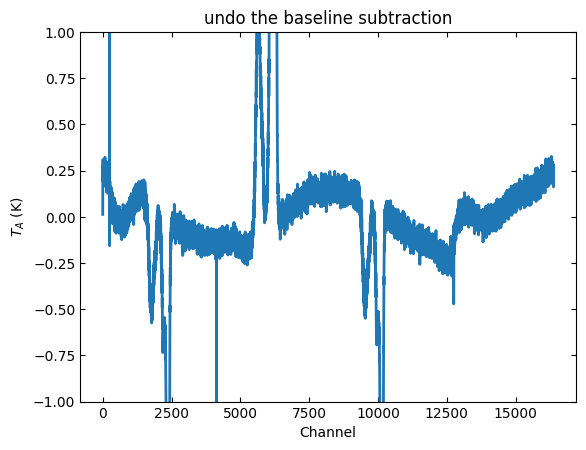

stats: -0.142315958298121 K 0.03631059232266146 K -0.00010205442179552853 K 0.04198114224875007 K


In [11]:
ta.undo_baseline()
ta.plot(xaxis_unit="chan",yaxis_unit="K",ymin=-1,ymax=1, title='undo the baseline subtraction')
rolled_stats(ta.flux[4200:5300])

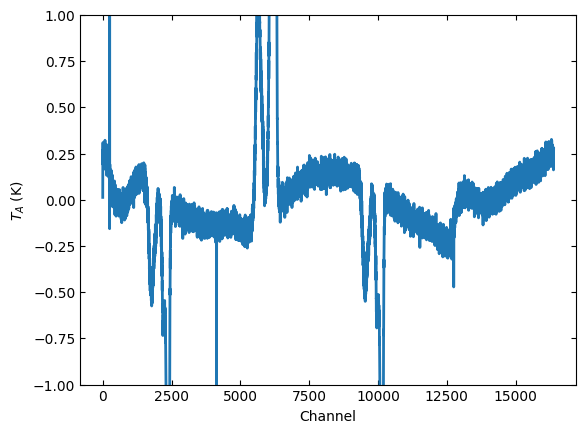

In [12]:
ta.plot(ymin=-1,ymax=1,xaxis_unit='channel', title='')

because we fitted in channel space, the units shown here are /Hz, but should be printed as /chan.

An alternative is to choose other models (e.g. chebychev) which normalize internally to unity.

In [13]:
ta.savefig("baselined_removed.png")

---

### Now do the calibration using selection

In [14]:
sdfits.select(scan=6,ifnum=0)

/home/teuben/GBT/dysh/src/dysh/spectra/core.py:350: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng] - caloff[chrng])


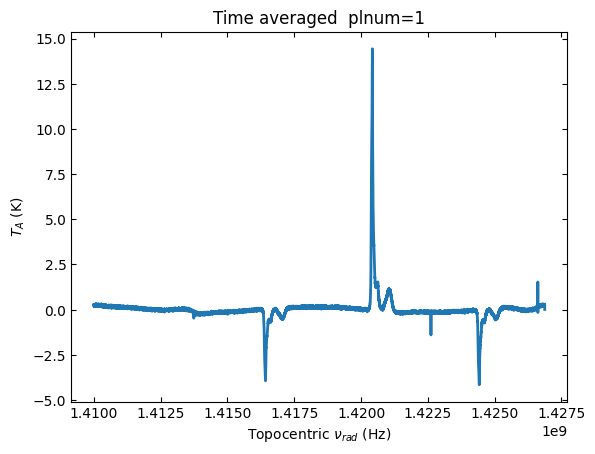

stats: -0.142315958298121 K 0.03631059232266146 K -0.00010205442179552853 K 0.04198114224875007 K


In [15]:
fsscan2=sdfits.getfs(plnum=1)
ta2=fsscan2.timeaverage()
ta2.plot(title='Time averaged  plnum=1')
rolled_stats(ta2.flux[4200:5300])

### Get the other polarization and plot

/home/teuben/GBT/dysh/src/dysh/spectra/core.py:350: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng] - caloff[chrng])


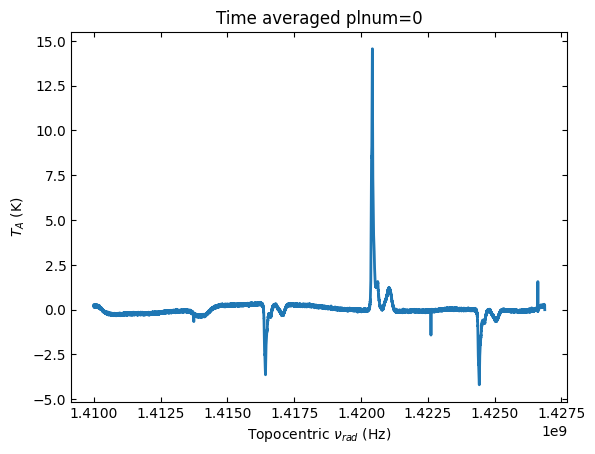

stats: -0.07441352094169922 K 0.03347822774530218 K -8.924251411633924e-06 K 0.04162023920078026 K


In [16]:
fsscan3=sdfits.getfs(plnum=0)
ta3=fsscan3.timeaverage()
ta3.plot(title='Time averaged plnum=0')
rolled_stats(ta3.flux[4200:5300])

### Average the polarizations


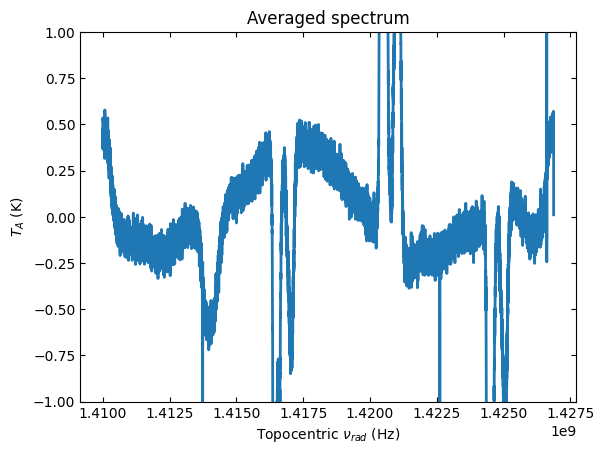

stats: -0.07870236920058438 K 0.04569367214106431 K -5.1286663749734676e-05 K 0.050795969714783964 K


In [17]:
avg = ta2+ta3
# avg = 0.5*avg       # bug, this doesn't work, but it worked in another form :-(    wait for a merge?
avg.plot(ymin=-1,ymax=1, title='Averaged spectrum')
rolled_stats(avg.flux[3000:5000]/2)     # div 2 because of the bug; did the noise go down?

The RMS has not improved, arguably regressed a bit from 42mK to 51mK in the rolled spectrum.  TBD.

## Behind the scenes:   raw spectra

Take it from us, the spectra are organized in batches of 4, and the first two are the "sig" calon/caloff, followed by the "ref" calon/caloff. Let's get the first 4 spectra and find out how frequency shifting works. They are called r0..r3 here:


In [18]:
r0 = sdfits.getspec(0)
r1 = sdfits.getspec(1)
r2 = sdfits.getspec(2)
r3 = sdfits.getspec(3)

Found BUNIT=None, now finding TUNIT7=, using the latter
Found BUNIT=None, now finding TUNIT7=, using the latter
Found BUNIT=None, now finding TUNIT7=, using the latter
Found BUNIT=None, now finding TUNIT7=, using the latter


Let's only plot the "sig" and "ref" as the calon/off are nearly identical.  You will see below that there is a birdie or bad channel in the "ref" spectrum, luckily not where the source (M33) is, so it should not pollute the subsequent calibration.

In a followup to this notebook, we shall find out how to identify this bad channel and mask it out. For now, lets carry on.

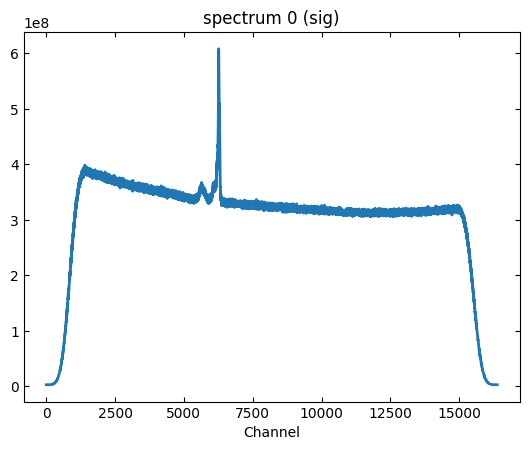

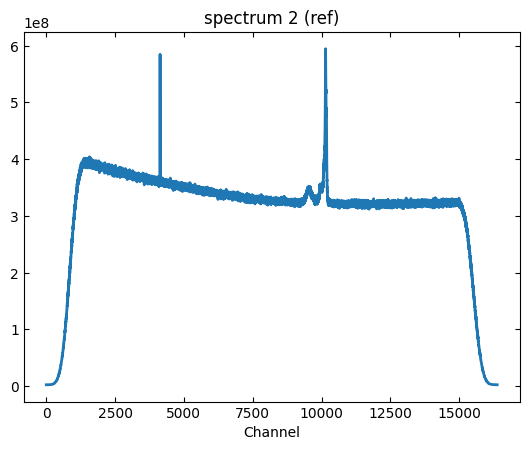

In [19]:
r0.plot(title='spectrum 0 (sig)', xaxis_unit="chan")
r2.plot(title='spectrum 2 (ref)', xaxis_unit="chan")


The calibration of a  calon/caloff for each of the sig and cal follows the same procedure as a **gettp()** call. 
